# SVM多类分类器

In [14]:
# 获取 CIFAR-10 数据集，并且处理成为train,validation,test 三部分
import numpy as np
import torch
import random
import pickle
# 加载 CIFAR-10 数据集
# 这里使用的是CIFAR-10 的 data_batch_1 共一万个数据，我自己划分为 train,validation,test 三部分
# 前 6000 为training set，接着3000为 validation set 最后1000为 test set

def load_train_data(filename):
    with open(filename,'rb') as f:
        datadict = pickle.load(f,encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3,32,32)
        Y = np.array(Y)
        return X,Y
    
    
root = 'data_batch_1'
(data, labels) = load_train_data(root)

data = data.reshape(10000,3072)
train_set = data[0:3000]
train_labels = labels[0:3000]

val_set = data[6000:7000]
val_labels = labels[6000:7000]

test_set = data[9000:9500]
test_labels = labels[9000:9500]

In [1]:
# 十分类器 SVM 分类器
# 尚未加入正则项
class SVM(object):
    def __init__(self,w,b,rate = 0.5):
        # 权重初始化, 更新率为超参数
        self.w = w
        self.b = b
        self.rate = rate
        
    def __str__(self):
        return 'weight:\t%s\nbias:\t%s' % (self.w,self.b)
    
    def weight(self):
        return (self.w,self.b)
        
    def train(self,train_set, labels, iteration,batch=30):
        self.batch = batch
        for i in range(iteration):
            self.Minibatch_Stochastic_gradient_descent(train_set,labels)# 小批量随机梯度下降
            #self.Stochastic_gradient_descent(train_set,labels)# 随机梯度下降
                
    def Minibatch_Stochastic_gradient_descent(self,train_set,train_labels):
        index = random.sample(range(len(train_labels)),self.batch)
        data = train_set[index,:]
        labels = train_labels[index]
        scores = np.dot(self.w,data.T) + b
        
        # 构造辅助向量 
        v = np.zeros((10,self.batch))
        for i in range(self.batch):
            v[:,i] = (scores[:,i] - scores[labels[i],i] + 1 > 0) + 0
            v[labels[i],i] = - np.sum(v[:,i]) + 1
        
        dw = np.dot(v,data) / self.batch
        db = np.mean(v,axis=1).reshape((10,1))
        
        self.w = self.w - self.rate * dw
        self.b = self.b - self.rate * db
        
    def Stochastic_gradient_descent(self, train_set, labels):
        index = random.randint(0,len(train_set)-1)
        data = train_set[index,:]
        label = labels[index]
        # 处理成矩阵
        data = data.reshape((3072,1))  # data 3072 * 1
             
        scores = self.w.dot(data) + self.b# score 10 * 1  
        
        Loss = np.sum(np.maximum(0,scores - (scores[label]-1)))-1 # 计算 loss 可以用作检测
        #print(Loss)
        
        # 更新过程        
        x = (scores - (scores[label]-1) > 0) + 0 # 构造辅助向量 x 10 * 1
        x[label] = - np.sum(x) + 1 
        
        dw = np.dot(x,data.T)
        db = x
        
        self.w = self.w - self.rate * dw
        self.b = self.b - self.rate * db
        
    def predict(self,Xpred):
        # 预测模块
        print(np.shape(self.b))
        Ypred = np.dot(self.w,Xpred.T)+self.b
        Ypred = Ypred.argmax(axis=0)
        return Ypred
                      

In [40]:
# 参数初始化
w = np.zeros((10,3072))
b = np.zeros((10,1))
rate = 0.5

# 训练过程
for rate in [1,0.8,0.6,0.5,0.2,0.1,1e-2,1e-3]:
    p = SVM(w,b,rate)
    p.train(train_set,train_labels,10000)
    val_pred = p.predict(val_set)
    count = np.sum(val_pred == val_labels)
    print('rate:%s\taccuracy in val: %s / %s == %s' % (rate,count, len(val_labels),count/len(val_labels)))

rate:1	accuracy in val: 175 / 1000 == 0.175
rate:0.8	accuracy in val: 230 / 1000 == 0.23
rate:0.6	accuracy in val: 277 / 1000 == 0.277
rate:0.5	accuracy in val: 238 / 1000 == 0.238
rate:0.2	accuracy in val: 214 / 1000 == 0.214
rate:0.1	accuracy in val: 302 / 1000 == 0.302
rate:0.01	accuracy in val: 248 / 1000 == 0.248
rate:0.001	accuracy in val: 207 / 1000 == 0.207


## 从上面我们知道rate = 0.1 效果比较好，接下来我们看随着迭代次数增加正确率的变化

In [47]:
# 参数初始化
w = np.zeros((10,3072))
b = np.zeros((10,1))
rate = 0.1
iteration = 1000

itera = [1000,2000,3000,4000,5000,10000,20000,50000,100000]
for iteration in itera:
    p = SVM(w,b,rate)
    p.train(train_set,train_labels,iteration)
    val_pred = p.predict(val_set)
    count = np.sum(val_pred == val_labels)
    print('rate:%s\taccuracy in val: %s / %s == %s' % (rate,count, len(val_labels),count/len(val_labels)))

rate:0.1	accuracy in val: 131 / 1000 == 0.131
rate:0.1	accuracy in val: 155 / 1000 == 0.155
rate:0.1	accuracy in val: 258 / 1000 == 0.258
rate:0.1	accuracy in val: 245 / 1000 == 0.245
rate:0.1	accuracy in val: 202 / 1000 == 0.202
rate:0.1	accuracy in val: 277 / 1000 == 0.277
rate:0.1	accuracy in val: 272 / 1000 == 0.272
rate:0.1	accuracy in val: 270 / 1000 == 0.27
rate:0.1	accuracy in val: 264 / 1000 == 0.264


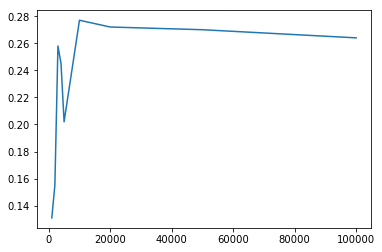

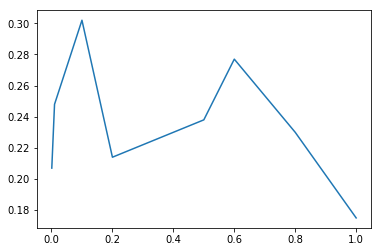

In [50]:
# 绘制准确率曲线
import matplotlib.pyplot as plt
acc = [0.131,0.155,0.258,0.245,0.202,0.277,0.272,0.27,0.264]
plt.figure()
plt.plot(itera,acc)
plt.show()

acc1 = [0.175,0.23,0.277,0.238,0.214,0.302,0.248,0.207]
rate1 = [1,0.8,0.6,0.5,0.2,0.1,1e-2,1e-3]
plt.figure()
plt.plot(rate1,acc1)
plt.show()

### 选择步长rate = 0.1， 迭代次数 10000 次，在测试集上做测试

In [51]:
# 参数初始化
w = np.zeros((10,3072))
b = np.zeros((10,1))
rate = 0.1
iteration = 10000
p = SVM(w,b,rate)
p.train(train_set,train_labels,iteration)
val_pred = p.predict(test_set)
count = np.sum(val_pred == test_labels)
print('rate:%s\taccuracy in test: %s / %s == %s' % (rate,count, len(test_labels),count/len(test_labels)))

rate:0.1	accuracy in test: 137 / 500 == 0.274


## MGD 方法

In [41]:
# 小批量随机梯度下降
# 参数初始化
w = np.zeros((10,3072))
b = np.zeros((10,1))
rate = 0.1

iteration = 1000
p = SVM(w,b,rate)
p.train(train_set,train_labels,iteration,batch=100)
val_pred = p.predict(val_set)
count = np.sum(val_pred == val_labels)
print('rate:%s\taccuracy in test: %s / %s == %s' % (rate,count, len(val_labels),count/len(val_labels)))

(10, 1)
rate:0.1	accuracy in test: 260 / 1000 == 0.26
